    Author: Eswar Lakshminarayanan

### Importing dependencies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from random import sample
import matplotlib.pyplot as plt 
from folium.plugins import HeatMap
import folium
import folium.plugins as plugins
%matplotlib inline

### Random sampling

In [2]:
n = 1764258 #number of records in file
s = 200000 #desired sample size
skip = sorted(sample(range(1,n),n-s))
df = pd.read_csv("new_levelB1_trajectory.csv",header=0,skiprows=skip)

### Filter really short and long trajectories

In [3]:
df = df.loc[(df.seq_len>10) & (df.seq_len<1500)]

In [4]:
df.shape

(200000, 5)

### Trajectory Length Distribution

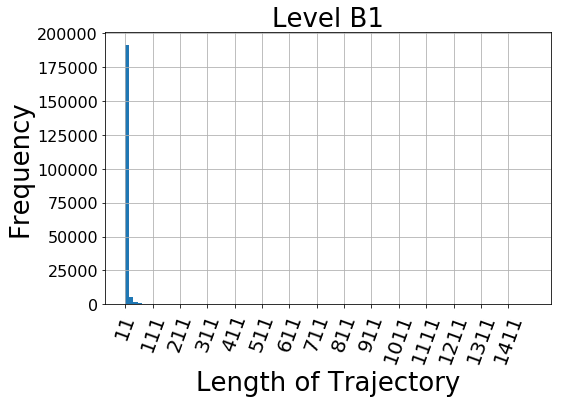

In [5]:
plt.figure(figsize=(8,5))
df.seq_len.hist(bins =100)
plt.xlabel("Length of Trajectory",fontsize=26)
plt.ylabel("Frequency",fontsize=26)
plt.title("Level B1",fontsize=26)
plt.xticks(np.arange(min(df.seq_len), max(df.seq_len)+1, 100),fontsize=20,rotation=70)
plt.yticks(fontsize=16)
plt.show()

### Extract Lat Lon from Trajectories

In [6]:
lat_lng =[]
#lat_lng_time = []
counter = 0
counter2 = 0
def fn(row):
    l1 = []
    l2 = []
    for each_recording in eval(row["loc_info"]):
        _,lat,lng,time = each_recording
        l1.append([lat,lng])
        #l2.append([lat,lng,time])
    lat_lng.append(l1)
    #lat_lng_time.append(l2)


In [7]:
df[["loc_info"]].apply(lambda x: fn(x),axis=1)
df=None

In [8]:
len(lat_lng)

200000

##  train split

In [9]:
X_train = []
Y_train = []

for each_traj in lat_lng[0:5000]:
    X_train.append(each_traj[:len(each_traj)-1])
    Y_train.append(each_traj[-1])
    

### Model Architectire

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,TimeDistributed
from keras.layers import Embedding
from keras.layers import LSTM
import numpy as np
import keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    euclidean_distance_loss.__name__ = "Custom Loss"
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

model = Sequential()
model.add(LSTM(256, return_sequences=True,input_shape=(None, 2))) 
model.add(LSTM(128, return_sequences=True)) 
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(2))
model.compile(loss=euclidean_distance_loss, optimizer='adam')
model.summary()


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 256)         265216    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 524,226
Trainable params: 524,226
Non-trainable params: 0
_________________________________________________________________


### Online Learning (Batch Size = 1)

In [11]:
counter = 0
loss = []
for x_seq,label in zip(X_train,Y_train):
    counter +=1
    if counter %10 ==0:
        print("# {} examples trained".format(counter))
    X_seq = np.array(x_seq).reshape(-1,len(x_seq), 2)
    y = np.array(label).reshape(1, 2) # predict next element
    history = model.fit(X_seq, y, batch_size=1, verbose=1, shuffle=False)
    loss.extend(history.history['loss'])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 103.8003
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 103.0727
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 102.6120
Epoch 1/1
1/1 [==============================] - 0s 218ms/step - loss: 102.2236
Epoch 1/1
1/1 [==============================] - 0s 490ms/step - loss: 101.8763
Epoch 1/1
1/1 [==============================] - 0s 103ms/step - loss: 101.5809
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 101.2730
Epoch 1/1
1/1 [==============================] - 1s 978ms/step - loss: 101.0062
Epoch 1/1
1/1 [==============================] - 0s 182ms/step - loss: 100.7536
# 10 examples trained
Epoch 1/1
1/1 [==============================] - 0s 154ms/step - loss: 100.5171
Epoch 1/1
1/1 [==============================] - 0s 115ms/step - loss: 100.3013
Epoch 1/1
1/1 [==============================] - 0s 73ms/step 

# 100 examples trained
Epoch 1/1
1/1 [==============================] - 0s 487ms/step - loss: 93.7018
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 93.6651
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 93.6283
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 93.5923
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 93.5556
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 93.5191
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 93.4824
Epoch 1/1
1/1 [==============================] - 0s 406ms/step - loss: 93.4459
Epoch 1/1
1/1 [==============================] - 1s 568ms/step - loss: 93.4095
Epoch 1/1
1/1 [==============================] - 0s 113ms/step - loss: 93.3731
# 110 examples trained
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 93.3369
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 93.3006
Epoch 1/1
1/1 [=======

Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 90.0978
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 90.0632
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 90.0286
Epoch 1/1
1/1 [==============================] - 0s 404ms/step - loss: 89.9946
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 89.9599
Epoch 1/1
1/1 [==============================] - 0s 319ms/step - loss: 89.9252
Epoch 1/1
1/1 [==============================] - 0s 112ms/step - loss: 89.8907
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 89.8562
# 210 examples trained
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 89.8218
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 89.7873
Epoch 1/1
1/1 [==============================] - 0s 160ms/step - loss: 89.7525
Epoch 1/1
1/1 [==============================] - 0s 451ms/step - loss: 89.7181
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 1s 518ms/step - loss: 86.6098
Epoch 1/1
1/1 [==============================] - 0s 319ms/step - loss: 86.5758
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 86.5418
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 86.5081
Epoch 1/1
1/1 [==============================] - 0s 104ms/step - loss: 86.4739
Epoch 1/1
1/1 [==============================] - 0s 370ms/step - loss: 86.4403
# 310 examples trained
Epoch 1/1
1/1 [==============================] - 0s 472ms/step - loss: 86.4062
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 86.3722
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 86.3384
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 86.3044
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 86.2710
Epoch 1/1
1/1 [==============================] - 0s 83ms/step - loss: 86.2366
Epoch 1/1
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 59ms/step - loss: 83.1641
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 83.1307
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 83.0964
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 83.0629
# 410 examples trained
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 83.0297
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 82.9958
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 82.9622
Epoch 1/1
1/1 [==============================] - 1s 716ms/step - loss: 82.9284
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 82.8951
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 82.8611
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 82.8275
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 82.7936
Epoch 1/1
1/1 [==============================] - 0s 

1/1 [==============================] - 1s 1s/step - loss: 79.7398
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 79.7068
# 510 examples trained
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 79.6731
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 79.6396
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 79.6065
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 79.5726
Epoch 1/1
1/1 [==============================] - 0s 450ms/step - loss: 79.5391
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 79.5056
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 79.4721
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 79.4386
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 79.4053
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 79.3715
# 520 examples trained
Epoch 1/1
1/1 [==================

Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 76.2963
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 76.2629
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 76.2296
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 76.1961
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 76.1627
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 76.1295
Epoch 1/1
1/1 [==============================] - 0s 72ms/step - loss: 76.0961
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 76.0625
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 76.0295
# 620 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 75.9960
Epoch 1/1
1/1 [==============================] - 1s 830ms/step - loss: 75.9626
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 75.9290
Epoch 1/1
1/1 [==============================] -

Epoch 1/1
1/1 [==============================] - 0s 344ms/step - loss: 72.8622
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 72.8285
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 72.7955
Epoch 1/1
1/1 [==============================] - 1s 952ms/step - loss: 72.7619
Epoch 1/1
1/1 [==============================] - 0s 97ms/step - loss: 72.7286
Epoch 1/1
1/1 [==============================] - 0s 116ms/step - loss: 72.6952
# 720 examples trained
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 72.6623
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 72.6289
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 72.5955
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 72.5621
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 72.5290
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 72.4954
Epoch 1/1
1/1 [===========================

Epoch 1/1
1/1 [==============================] - 0s 97ms/step - loss: 69.4672
Epoch 1/1
1/1 [==============================] - 0s 145ms/step - loss: 69.4340
Epoch 1/1
1/1 [==============================] - 0s 104ms/step - loss: 69.4007
Epoch 1/1
1/1 [==============================] - 0s 218ms/step - loss: 69.3675
# 820 examples trained
Epoch 1/1
1/1 [==============================] - 0s 108ms/step - loss: 69.3342
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 69.3010
Epoch 1/1
1/1 [==============================] - 0s 148ms/step - loss: 69.2677
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 69.2345
Epoch 1/1
1/1 [==============================] - 0s 116ms/step - loss: 69.2012
Epoch 1/1
1/1 [==============================] - 0s 114ms/step - loss: 69.1679
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 69.1348
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 69.1015
Epoch 1/1
1/1 [===================

Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 66.0778
Epoch 1/1
1/1 [==============================] - 0s 156ms/step - loss: 66.0445
# 920 examples trained
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 66.0112
Epoch 1/1
1/1 [==============================] - 0s 348ms/step - loss: 65.9778
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 65.9446
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 65.9114
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 65.8782
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 65.8450
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 65.8118
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 65.7788
Epoch 1/1
1/1 [==============================] - 0s 46ms/step - loss: 65.7457
Epoch 1/1
1/1 [==============================] - 0s 456ms/step - loss: 65.7122
# 930 examples trained
Epoch 1/1
1/1 [============

1/1 [==============================] - 0s 59ms/step - loss: 62.6914
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 62.6583
Epoch 1/1
1/1 [==============================] - 1s 632ms/step - loss: 62.6251
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 62.5919
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 62.5589
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 62.5255
Epoch 1/1
1/1 [==============================] - 0s 407ms/step - loss: 62.4928
Epoch 1/1
1/1 [==============================] - 1s 766ms/step - loss: 62.4595
Epoch 1/1
1/1 [==============================] - 0s 328ms/step - loss: 62.4264
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 62.3934
# 1030 examples trained
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 62.3595
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 62.3266
Epoch 1/1
1/1 [==============================] -

Epoch 1/1
1/1 [==============================] - 1s 516ms/step - loss: 59.3089
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 59.2754
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 59.2424
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 59.2091
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 59.1759
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 59.1431
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 59.1096
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 59.0767
# 1130 examples trained
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 59.0433
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 59.0102
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 58.9770
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 58.9441
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 147ms/step - loss: 55.9282
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 55.8949
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 55.8615
Epoch 1/1
1/1 [==============================] - 0s 86ms/step - loss: 55.8287
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 55.7955
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 55.7624
# 1230 examples trained
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 55.7292
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 55.6961
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 55.6633
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 55.6298
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 55.5965
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 55.5636
Epoch 1/1
1/1 [==========================

Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 52.5496
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 52.5162
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 52.4832
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 52.4500
# 1330 examples trained
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 52.4169
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 52.3839
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 52.3509
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 52.3174
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 52.2844
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 52.2515
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 52.2182
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 52.1857
Epoch 1/1
1/1 [=========================

Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 49.1725
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 49.1398
# 1430 examples trained
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 49.1062
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 49.0729
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 49.0400
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 49.0070
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 48.9738
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 48.9408
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 48.9079
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 48.8744
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 48.8415
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 48.8084
# 1440 examples trained
Epoch 1/1
1/1 [=

# 1530 examples trained
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 45.7967
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 45.7637
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 45.7308
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 45.6977
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 45.6646
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 45.6314
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 45.5986
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 45.5653
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 45.5321
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 45.4992
# 1540 examples trained
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 45.4662
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 45.4332
Epoch 1/1
1/1 [=

Epoch 1/1
1/1 [==============================] - 0s 72ms/step - loss: 42.4227
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 42.3894
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 42.3562
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 42.3231
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 42.2901
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 42.2570
Epoch 1/1
1/1 [==============================] - 0s 116ms/step - loss: 42.2238
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 42.1911
# 1640 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 42.1578
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 42.1247
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 42.0914
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 42.0586
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 39.0491
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 39.0160
Epoch 1/1
1/1 [==============================] - 0s 76ms/step - loss: 38.9830
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 38.9497
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 38.9172
Epoch 1/1
1/1 [==============================] - 0s 89ms/step - loss: 38.8837
# 1740 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 38.8507
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 38.8175
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 38.7844
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 38.7514
Epoch 1/1
1/1 [==============================] - 0s 122ms/step - loss: 38.7183
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 38.6853
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 35.6766
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 35.6436
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 35.6106
Epoch 1/1
1/1 [==============================] - 0s 72ms/step - loss: 35.5773
# 1840 examples trained
Epoch 1/1
1/1 [==============================] - 0s 54ms/step - loss: 35.5443
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 35.5113
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 35.4781
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 35.4451
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 35.4122
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 35.3789
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 35.3456
Epoch 1/1
1/1 [==============================] - 0s 83ms/step - loss: 35.3128
Epoch 1/1
1/1 [=========================

Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 32.3048
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 32.2720
# 1940 examples trained
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 32.2387
Epoch 1/1
1/1 [==============================] - 0s 93ms/step - loss: 32.2057
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 32.1725
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 32.1395
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 32.1064
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 32.0734
Epoch 1/1
1/1 [==============================] - 0s 50ms/step - loss: 32.0404
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 32.0071
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 31.9742
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 31.9412
# 1950 examples trained
Epoch 1/1
1/1 [=

# 2040 examples trained
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 28.9337
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 28.9009
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 28.8676
Epoch 1/1
1/1 [==============================] - 0s 86ms/step - loss: 28.8344
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 28.8016
Epoch 1/1
1/1 [==============================] - 0s 119ms/step - loss: 28.7686
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 28.7351
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 28.7023
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 28.6692
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 28.6361
# 2050 examples trained
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 28.6029
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 28.5701
Epoch 1/1
1/1 [==

Epoch 1/1
1/1 [==============================] - 0s 101ms/step - loss: 25.5629
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 25.5300
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 25.4970
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 25.4639
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 25.4309
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 25.3977
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 25.3648
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 25.3322
# 2150 examples trained
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 25.2990
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 25.2659
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 25.2329
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 25.1996
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 22.1928
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 22.1599
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 22.1269
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 22.0938
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 22.0609
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 22.0277
# 2250 examples trained
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 21.9948
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 21.9618
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 21.9288
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 21.8956
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 21.8626
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 21.8293
Epoch 1/1
1/1 [=========================

Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 18.8236
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 18.7901
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 18.7573
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 18.7242
# 2350 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 18.6911
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 18.6582
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 18.6252
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 18.5922
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 18.5592
Epoch 1/1
1/1 [==============================] - 0s 80ms/step - loss: 18.5262
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 18.4932
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 18.4600
Epoch 1/1
1/1 [=========================

Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 15.4542
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 15.4213
# 2450 examples trained
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 15.3881
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 15.3554
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 15.3222
Epoch 1/1
1/1 [==============================] - 0s 95ms/step - loss: 15.2889
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 15.2558
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 15.2229
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 15.1903
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 15.1569
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 15.1239
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 15.0908
# 2460 examples trained
Epoch 1/1
1/1 [===

# 2550 examples trained
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 12.0857
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 12.0520
Epoch 1/1
1/1 [==============================] - 0s 115ms/step - loss: 12.0192
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 11.9862
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 11.9530
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 11.9201
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 11.8870
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 11.8543
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 11.8211
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 11.7880
# 2560 examples trained
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 11.7551
Epoch 1/1
1/1 [==============================] - 0s 97ms/step - loss: 11.7219
Epoch 1/1
1/1 [

1/1 [==============================] - 0s 56ms/step - loss: 8.7168
Epoch 1/1
1/1 [==============================] - 0s 128ms/step - loss: 8.6839
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 8.6506
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 8.6176
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 8.5847
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 8.5515
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 8.5187
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 8.4856
# 2660 examples trained
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 8.4527
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 8.4195
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 8.3865
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 8.3535
Epoch 1/1
1/1 [==============================] - 0s 149ms/ste

Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 5.2824
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 5.2494
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 5.2162
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 5.1833
# 2760 examples trained
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 5.1503
Epoch 1/1
1/1 [==============================] - 0s 50ms/step - loss: 5.1172
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 5.0843
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 5.0514
Epoch 1/1
1/1 [==============================] - 0s 84ms/step - loss: 5.0183
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 4.9852
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 4.9520
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 4.9191
Epoch 1/1
1/1 [==============================] - 0s 

# 2860 examples trained
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 1.8483
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 1.8152
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 1.7823
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 1.7493
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 1.7161
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 1.6832
Epoch 1/1
1/1 [==============================] - 0s 100ms/step - loss: 1.6502
Epoch 1/1
1/1 [==============================] - 0s 97ms/step - loss: 1.6175
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 1.5841
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 1.5513
# 2870 examples trained
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 1.5180
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 1.4852
Epoch 1/1
1/1 [============

Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0062
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0228
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 0.0200
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0141
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 0.0210
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 0.0103
# 2970 examples trained
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0172
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0142
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0128
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0162
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 0.0090
Epoch 1/1
1/1 [==============================] - 0s 

Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 0.0078
Epoch 1/1
1/1 [==============================] - 0s 113ms/step - loss: 0.0120
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 0.0063
# 3070 examples trained
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0099
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0134
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0077
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0080
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0122
Epoch 1/1
1/1 [==============================] - 0s 140ms/step - loss: 0.0063
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0093
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0137
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s 144ms/step - loss: 0.0094
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0048
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0071
Epoch 1/1
1/1 [==============================] - 0s 86ms/step - loss: 0.0096
Epoch 1/1
1/1 [==============================] - 0s 92ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 0.0071
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0100
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0064
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 0.0096
# 3180 examples trained
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 0.0066
Epoch 1/1
1/1 [==============================] - 0s 59ms/step

Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0083
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 0.0060
Epoch 1/1
1/1 [==============================] - 0s 213ms/step - loss: 0.0088
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0043
# 3280 examples trained
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0054
Epoch 1/1
1/1 [==============================] - 0s 76ms/step - loss: 0.0083
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0076
Epoch 1/1
1/1 [==============================] - 0s 89ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s

Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0049
# 3380 examples trained
Epoch 1/1
1/1 [==============================] - 0s 473ms/step - loss: 0.0065
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0055
Epoch 1/1
1/1 [==============================] - 0s 361ms/step - loss: 0.0078
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.0066
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.0031
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.0058
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.0077
# 3390 examples trained
Epoch 1/1
1/1 [===========================

Epoch 1/1
1/1 [==============================] - 0s 128ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0073
Epoch 1/1
1/1 [==============================] - 1s 786ms/step - loss: 0.0048
Epoch 1/1
1/1 [==============================] - 0s 252ms/step - loss: 0.0029
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 1s 971ms/step - loss: 0.0043
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0014
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0048
# 3490 examples trained
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0038
Epoch 1/1
1/1 [==============================] - 0s 314ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 1s 836ms/step - loss: 0.0021
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 63ms

1/1 [==============================] - 0s 63ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0032
# 3590 examples trained
Epoch 1/1
1/1 [==============================] - 0s 83ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0033
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0029
Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 74ms/step 

Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0024
# 3690 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0033
Epoch 1/1
1/1 [==============================] - 0s 475ms/step - loss: 8.7321e-04
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 0s 173ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0012
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 0.0029
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0015
# 3700 examples trained
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 0.0032
Epoch 1/1
1/1 [=======

Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 152ms/step - loss: 0.0020
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 243ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0029
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0055
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0027
# 3800 examples trained
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 0.0043
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0060
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 0.0037
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0033
Epoch 1/1
1/1 [==============================] - 0

Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0070
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 0.0031
# 3900 examples trained
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 84ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 96ms/step - loss: 0.0017
Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 

Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0029
# 4000 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 72ms/step - loss: 0.0019
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0010
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 3.7207e-04
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0026
# 4010 examples trained
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0030
Epoch 1/1
1/1 [=========

Epoch 1/1
1/1 [==============================] - 0s 101ms/step - loss: 0.0046
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 0.0066
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0038
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0059
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0050
# 4110 examples trained
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 0s 349ms/step - loss: 0.0063
Epoch 1/1
1/1 [==============================] - 0s 413ms/step - loss: 0.0037
Epoch 1/1
1/1 [==============================] - 

1/1 [==============================] - 0s 63ms/step - loss: 0.0021
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0080
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0119
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0113
Epoch 1/1
1/1 [==============================] - 0s 111ms/step - loss: 0.0060
# 4210 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0040
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0074
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0073
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0048
Epoch 1/1
1/1 [==============================] - 0s 96ms/step - loss: 0.0061
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 0.0052
Epoch 1/1
1/1 [==============================] - 0s 63ms/step

Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0049
# 4310 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0065
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0063
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0037
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0038
Epoch 1/1
1/1 [==============================] - 0s 89ms/step - loss: 0.0038
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0048
# 4320 examples trained
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0042
Epoch 1/1
1/1 [===============

Epoch 1/1
1/1 [==============================] - 0s 209ms/step - loss: 0.0107
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0097
Epoch 1/1
1/1 [==============================] - 0s 152ms/step - loss: 0.0048
Epoch 1/1
1/1 [==============================] - 0s 310ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 270ms/step - loss: 0.0078
Epoch 1/1
1/1 [==============================] - 0s 123ms/step - loss: 0.0069
Epoch 1/1
1/1 [==============================] - 0s 311ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0065
# 4420 examples trained
Epoch 1/1
1/1 [==============================] - 0s 174ms/step - loss: 0.0098
Epoch 1/1
1/1 [==============================] - 0s 161ms/step - loss: 0.0085
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0031
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0063
Epoch 1/1
1/1 [=============================

1/1 [==============================] - 0s 61ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 46ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 0.0036
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0046
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0017
# 4520 examples trained
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 0.0062
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0072
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0048
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0019
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0040
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - 

Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0026
# 4620 examples trained
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 233ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 94ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0018
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 91ms/step - loss: 0.0025
# 4630 examples trained
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0029
Epoch 1/1
1/1 [============

Epoch 1/1
1/1 [==============================] - 0s 106ms/step - loss: 0.0043
Epoch 1/1
1/1 [==============================] - 0s 165ms/step - loss: 9.8282e-04
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0065
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0082
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 0.0027
# 4730 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0040
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================]

1/1 [==============================] - 0s 63ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0018
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 0.0104
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0093
# 4830 examples trained
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0043
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 0.0083
Epoch 1/1
1/1 [==============================] - 0s 60ms/step - loss: 0.0073
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0062
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 0.0099
Epoch 1/1
1/1 [==============================] - 0s 60ms/step 

Epoch 1/1
1/1 [==============================] - 0s 115ms/step - loss: 0.0073
# 4930 examples trained
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 0.0016
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0073
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0108
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0099
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0071
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0064
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0018
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0066
# 4940 examples trained
Epoch 1/1
1/1 [==============================] - 0s 324ms/step - loss: 0.0099
Epoch 1/1
1/1 [===========

### Loss VS # of training examples

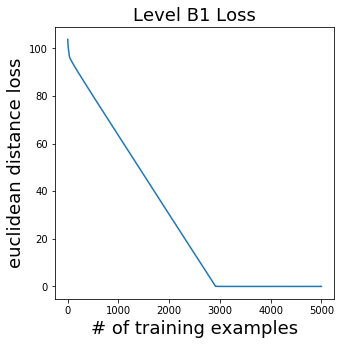

In [12]:
y = loss
x = list(range(1,len(loss)+1))
plt.figure(figsize=(5,5))
plt.plot(x, y)
plt.xlabel("# of training examples",fontsize=18)
plt.ylabel("euclidean distance loss",fontsize=18)
plt.title("Level B1 Loss",fontsize=18)
plt.show()

### Test the model

In [13]:
from scipy.spatial.distance import euclidean

from sklearn.metrics.pairwise import euclidean_distances

test_set =  lat_lng[10000:15000]
predicted_val =[]
for i,each_traj in enumerate(test_set):
    x_test = each_traj[:len(each_traj) -1]
    x_test = np.array(x_test).reshape(1, len(x_test), 2)
    y_test = each_traj[-1]
    y_test = np.array(y_test).reshape(1,2)
    y_pred = model.predict(x_test)
    predicted_val.append(y_pred.tolist()[0])
        
new_predicted_val = []
for sublst in predicted_val:
    for i, val in enumerate(sublst):
        sublst[i] = round(val, 7)
    new_predicted_val.append(sublst)    

### Test Error

In [14]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
error = []
for each_traj,y_pred in zip(test_set,new_predicted_val):
    y_test = each_traj[-1]
    error.extend(euclidean_distances([y_test],[y_pred]))
        
print("test error",np.mean(error))   

test error 0.007865015328699107


### Example plot Predicted vs True Trajectory


  <tr>
    <td> <img src="http://drive.google.com/uc?export=view&id=1gjgEflz3Q8GmGZ21dhjPOlJMb-6ZQ80G" alt="Drawing" style="width: 500px;"/> </td>
    <td> <img src="http://drive.google.com/uc?export=view&id=1T1K2H2_DTuE_xWXz1pfeAtB57QksoTEe" alt="Drawing" style="width: 500px;"/> </td>
    </tr>
    

### Centroids from K- Means models

In [15]:
centroids = [[1.2901505322971618, 103.85151526415854],
 [1.290761314882777, 103.85183701616937],
 [1.2898866212491749, 103.85139324211389],
 [1.2903683538500839, 103.85163185742208],
 [1.2908584102736864, 103.8519792337393],
 [1.290061721528241, 103.85165098408669],
 [1.290055102350767, 103.85144672301637],
 [1.2906218405153758, 103.85173958428693],
 [1.2897596030983194, 103.85130943752183],
 [1.2902503772023322, 103.85156459994279]]

### Calculate Visitors near each Cluster - Using True Label

In [20]:
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
calc_cluster = []
for each_traj in lat_lng[10000:15000]:
    label = each_traj[-1]
    label = np.array(label).reshape(1,2)   
    local_cluster = []
    for center in centroids:
        #print(float(euclidean_distances(label.tolist(), [center])[0][0]))
        local_cluster.append(euclidean_distances(label.tolist(), [center])[0][0]) 
    calc_cluster.append(np.argmin(local_cluster))

In [21]:
Counter(calc_cluster)

Counter({7: 359,
         1: 272,
         8: 399,
         6: 568,
         0: 940,
         4: 728,
         2: 571,
         9: 548,
         3: 308,
         5: 307})

### Calculate Visitors near each Cluster - Using Predicted Label

In [31]:
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
calc_cluster = []
for each_traj in new_predicted_val:
    label = each_traj
    label = np.array(label).reshape(1,2)   
    local_cluster = []
    for center in centroids:
        #print(float(euclidean_distances(label.tolist(), [center])[0][0]))
        local_cluster.append(euclidean_distances(label.tolist(), [center])[0][0]) 
    calc_cluster.append(np.argmin(local_cluster))

In [32]:
Counter(calc_cluster)

Counter({7: 396,
         5: 244,
         1: 168,
         3: 132,
         8: 25,
         9: 1801,
         4: 718,
         0: 690,
         6: 474,
         2: 352})

In [ ]:
# def np_haversine(latlon1, latlon2):
#     """
#     Numpy version of the Haversine function to calculate distances between two sets of points.
#     Returns the distance in miles.
#     """
#     lat1 = latlon1[:, 0]
#     lon1 = latlon1[:, 1]
#     lat2 = latlon2[:, 0]
#     lon2 = latlon2[:, 1]
    
#     REarth = 3961
#     lat = np.abs(lat1 - lat2) * np.pi / 180
#     lon = np.abs(lon1 - lon2) * np.pi / 180
#     lat1 = lat1 * np.pi / 180
#     lat2 = lat2 * np.pi / 180
#     a = np.sin(lat / 2) * np.sin(lat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(lon / 2) * np.sin(lon / 2)
#     d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     return REarth * d
# for each_traj in lat_lng[15000:20000]:
#     label = each_traj[-1]
#     new_predicted_val.append(label)
    